First, load the data,in this notebook we are using the smokoy mountain data as the example

In [1]:
import sys
sys.path.append('./Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("./Data/merge_proportion_asv_smoky_moutain.csv")

In [3]:
data

array([[1.5786533e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.6912335e-02, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0700000e-05,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        8.2400000e-05, 8.2400000e-05],
       [1.5771320e-03, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]])

In [4]:
data=RunML.normalizingMatrixToRanks(data,cutOff=0.01)
print(np.shape(data))

(59, 1768)


In [5]:
data

array([[1746.,    0.,    0., ...,    0.,    0.,    0.],
       [1753.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

Perform multiLabel feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [6]:
yList=[list(burn_label),list(un_label),list(duration_label)]

In [7]:
weights=FS.multiLabelFeatureWeighting(data,yList)

In [8]:
len(weights)

1768

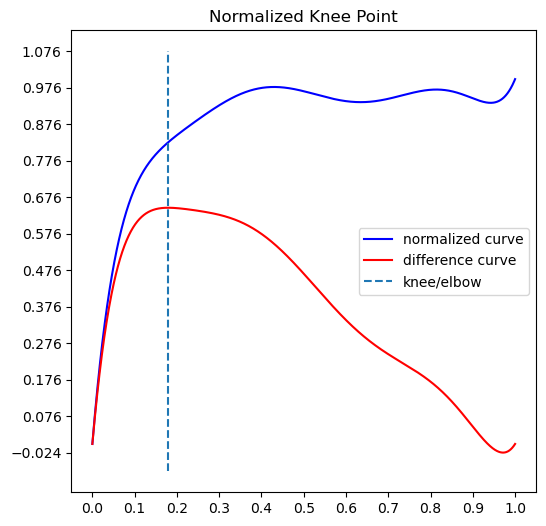

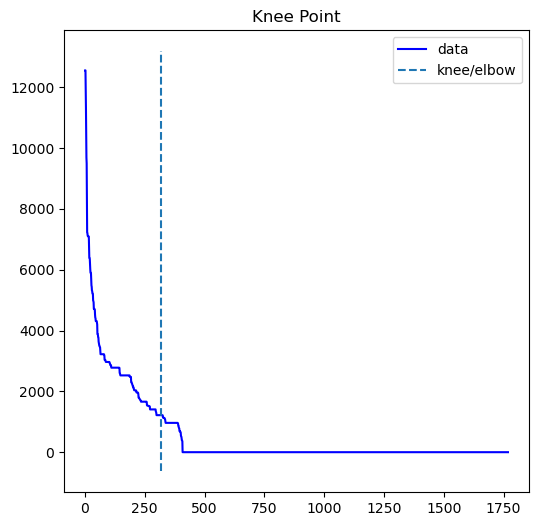

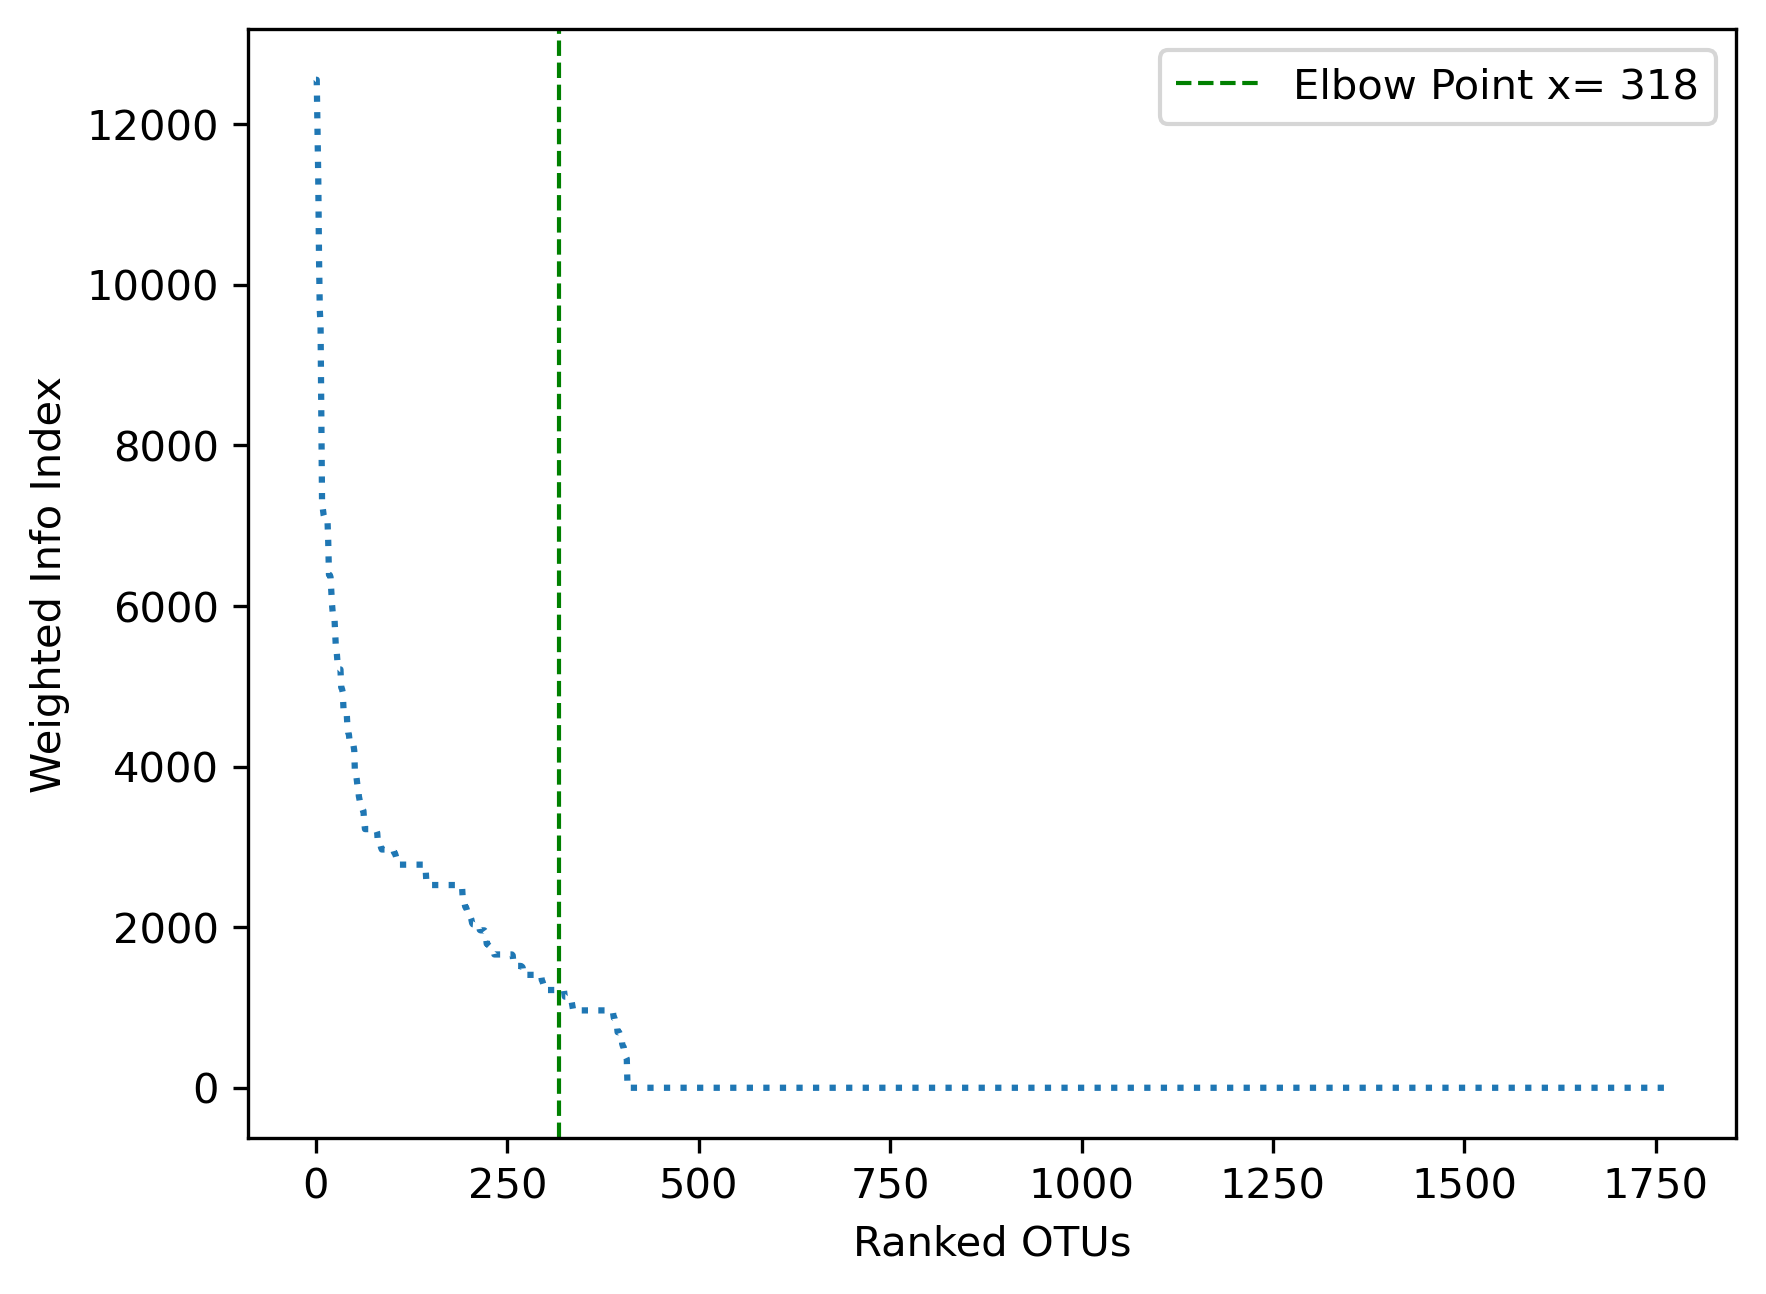

In [9]:
scores=(sorted(weights,reverse=True))
eps=FS.elbowPoint(scores)
FS.plotWeightedIndex(weights,xKnee=eps)

This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [10]:
topFeature_selected=eps
print(eps)

X_FS,selectedOTU_index=FS.feature_select(data,yList,topFeature=topFeature_selected)
print (np.shape(X_FS))


318
(59, 318)


In [11]:
print(len(weights))

1768


Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method, repeat the  process iter=20 times to  find the mean accuracy and AUC)---> use random forest and SVM as classifier

In [12]:
un_label.value_counts()

Urban      33
Natural    26
Name: UN, dtype: int64

In [13]:
iter =10
cls = ["RF","SVM"]

In [14]:
targetLabel=un_label
X_lasso = RunML.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)

In [15]:

data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }


In [16]:
data

array([[1746.,    0.,    0., ...,    0.,    0.,    0.],
       [1753.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [17]:
print(np.shape(X_lasso))
#np.shape(X_FS)
print(np.shape(data))

(59, 284)
(59, 1768)


started modeling, the  function will print out the accuracy and AUC for each dataset using each classifier. and also will return the y_actual, y_predict, y_predprob

In [18]:
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.559091  0.661111      0.678788  0.726349
SelectMicro     0.593939  0.691825      0.678788  0.791270
Lasso           0.540909  0.636508      0.692424  0.725714
Random          0.607879  0.651206      0.601515  0.495643


In [19]:
# Save dictionary to a pickle file
with open('results/dict_cm_smocky_un.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm, pickle_file)

In [20]:
# Load dictionary from the pickle file
with open('results/dict_cm_smocky_un.pkl', 'rb') as pickle_file:
    dict_cm = pickle.load(pickle_file)

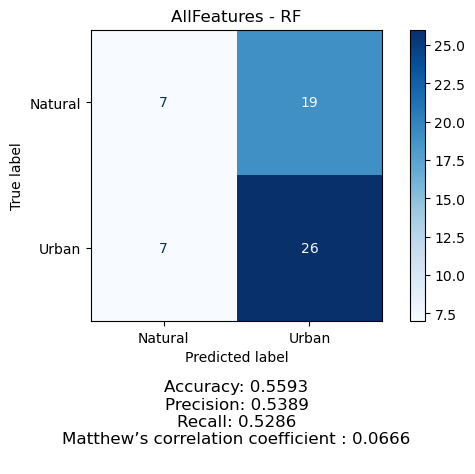

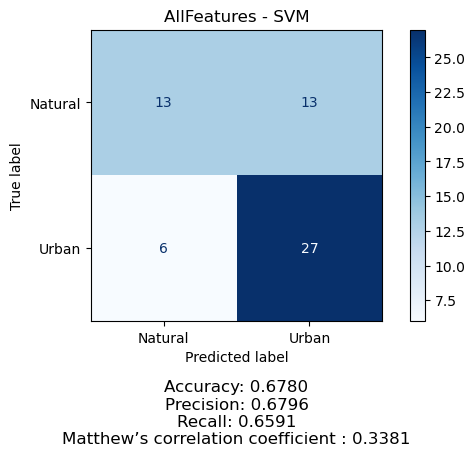

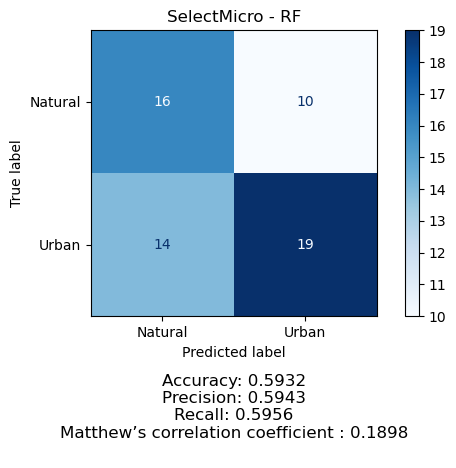

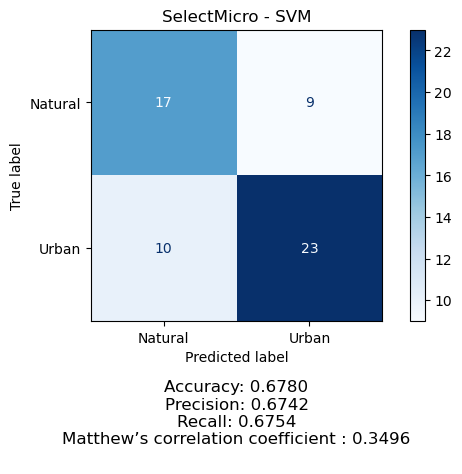

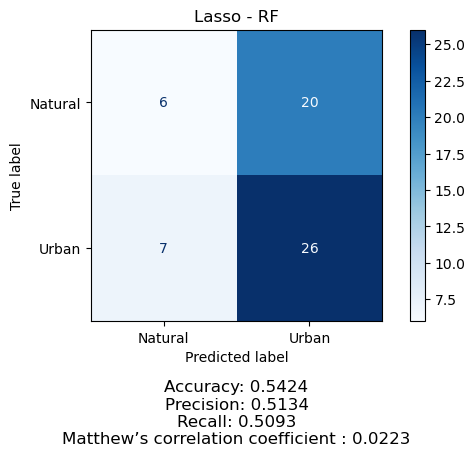

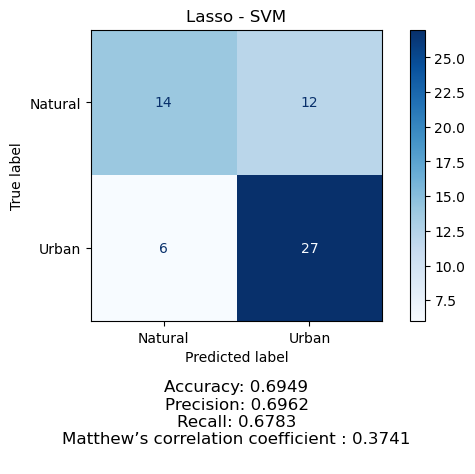

In [21]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [22]:
targetLabel=burn_label
X_lasso = RunML.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }

In [23]:
dict_cm_burn = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.780303  0.901157      0.880303  0.922454
SelectMicro     0.846970  0.928935      0.880303  0.949537
Lasso           0.830303  0.949306      0.880303  0.922454
Random          0.801364  0.847211      0.783788  0.772407


In [24]:
# Save dictionary to a pickle file
with open('results/dict_cm_smocky_burn.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm_burn, pickle_file)

In [25]:
# Load dictionary from the pickle file
with open('results/dict_cm_smocky_burn.pkl', 'rb') as pickle_file:
    dict_cm_burn = pickle.load(pickle_file)

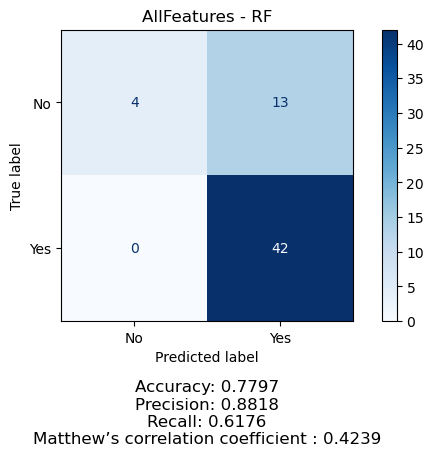

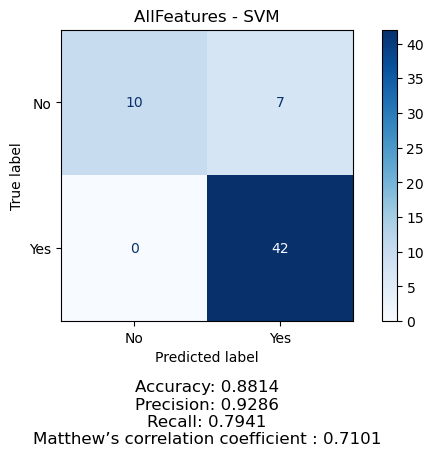

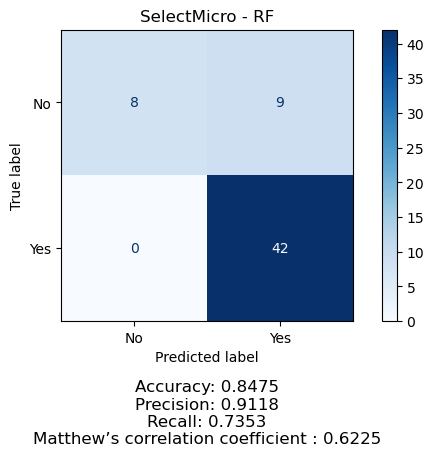

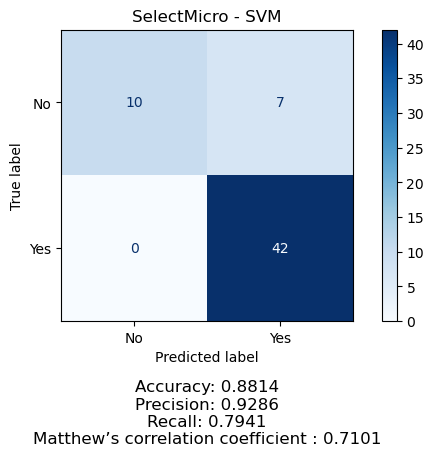

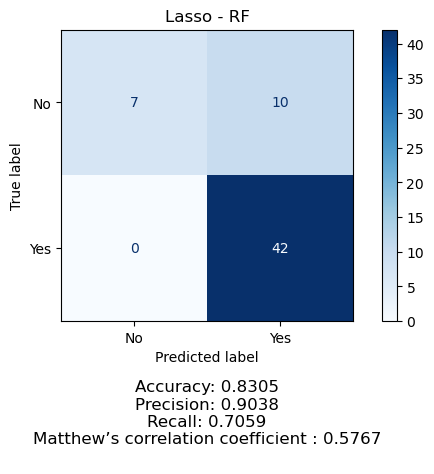

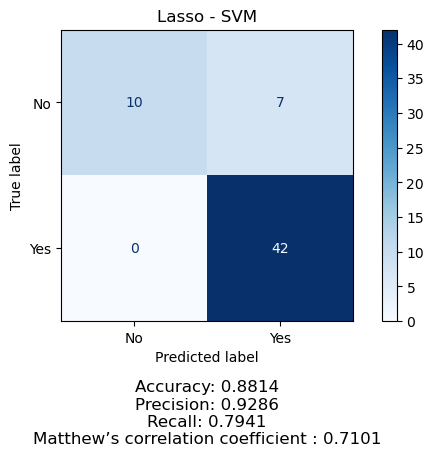

In [26]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm_burn.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

In [27]:
targetLabel=duration_label
X_lasso = RunML.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }

dict_cm_dur = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

             RF_Accuracy    RF_AUC  SVM_Accuracy   SVM_AUC
AllFeatures     0.524242  0.509375      0.640909  0.628929
SelectMicro     0.592424  0.652054      0.610606  0.647679
Lasso           0.574242  0.529732      0.640909  0.665357
Random          0.549394  0.481839      0.521818  0.484580


In [28]:
# Save dictionary to a pickle file
with open('results/dict_cm_smocky_dur.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm_dur, pickle_file)

In [29]:
# Load dictionary from the pickle file
with open('results/dict_cm_smocky_dur.pkl', 'rb') as pickle_file:
    dict_cm_dur = pickle.load(pickle_file)

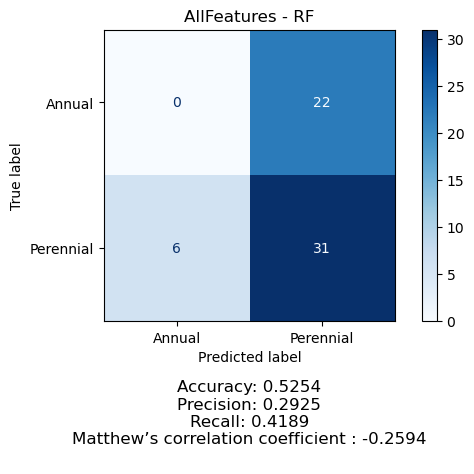

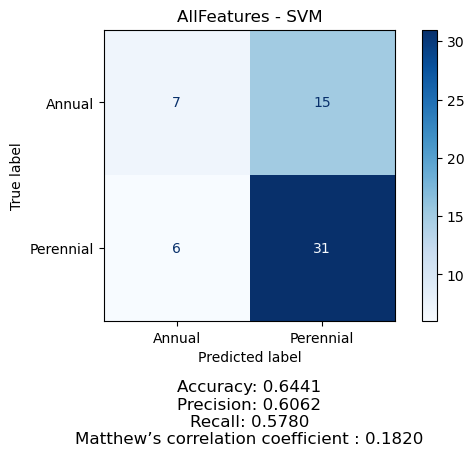

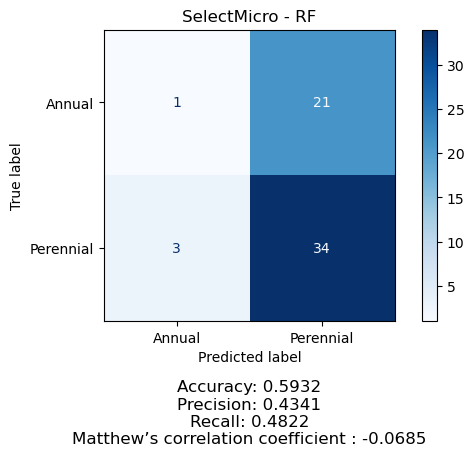

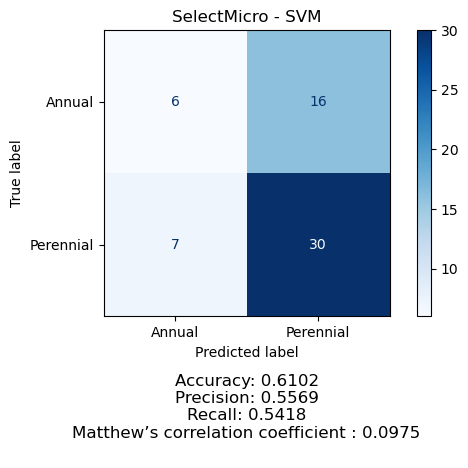

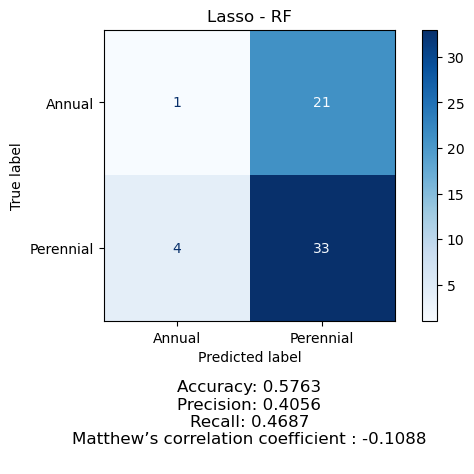

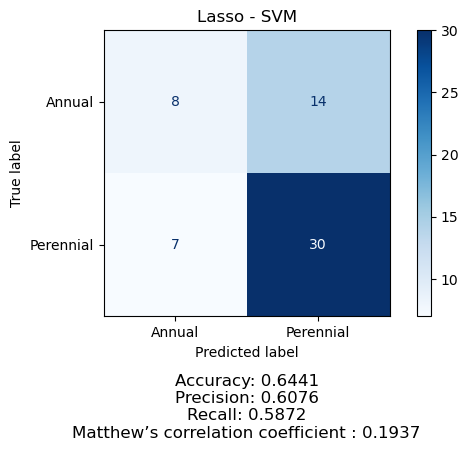

In [30]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm_dur.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

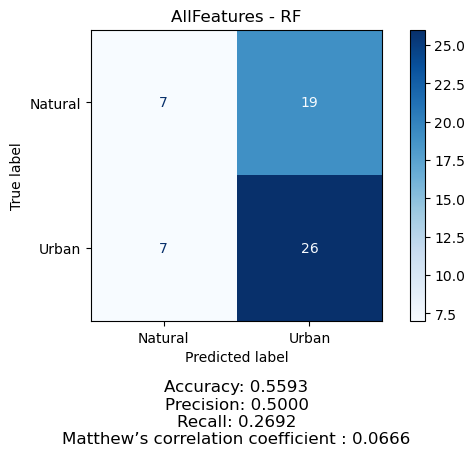

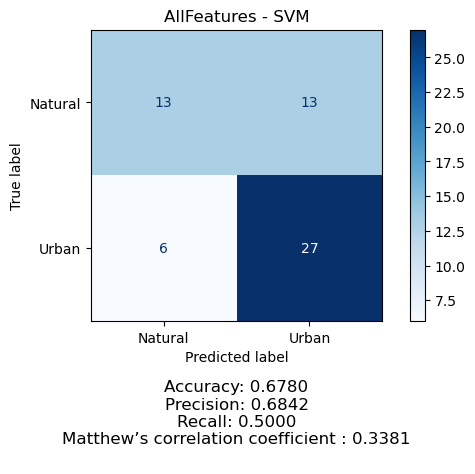

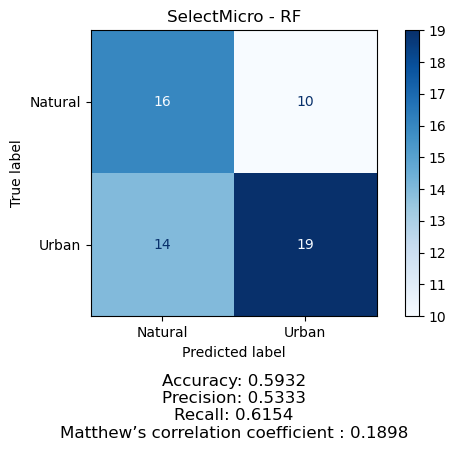

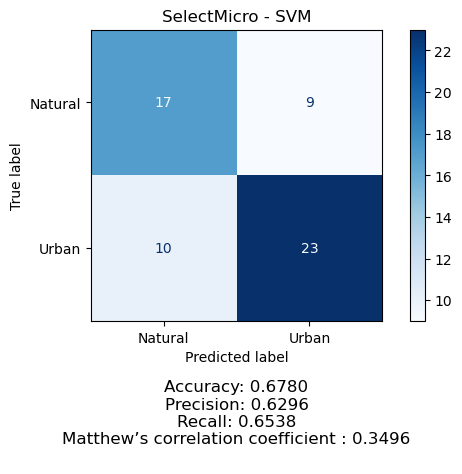

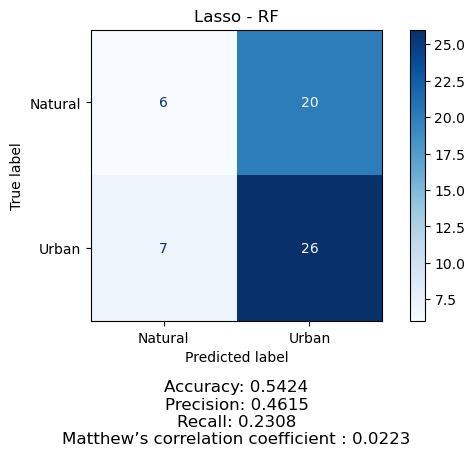

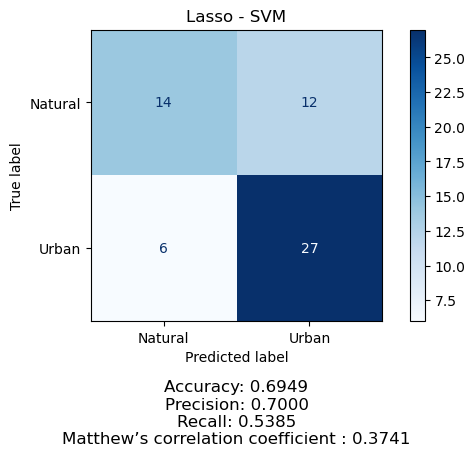

In [31]:
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}",pos_y='Natural')

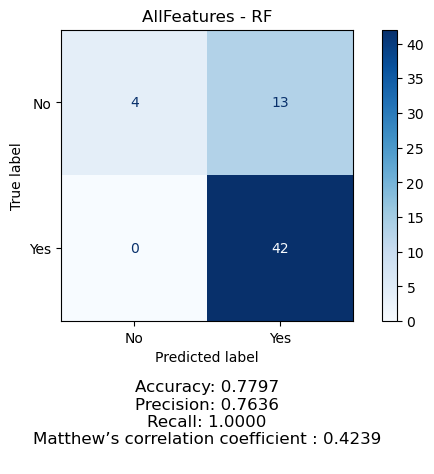

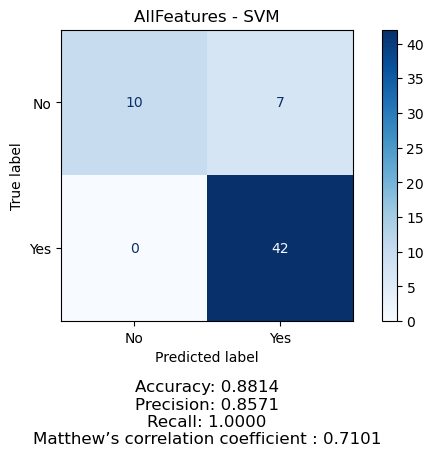

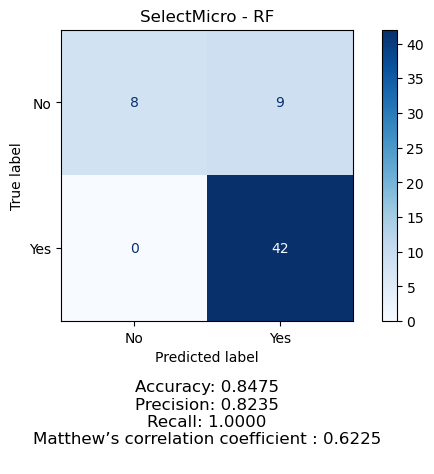

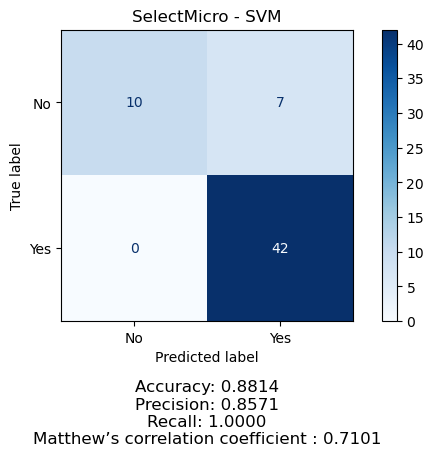

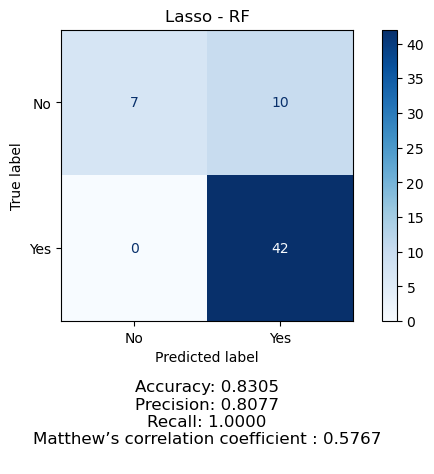

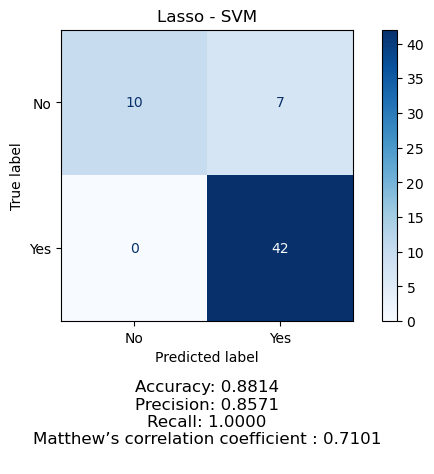

In [32]:
for dataset_name, classifiers in dict_cm_burn.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}",pos_y='Yes')

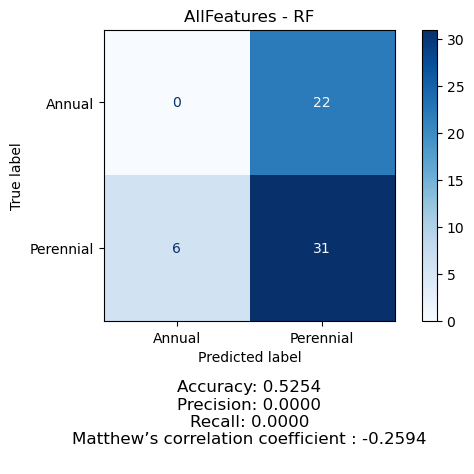

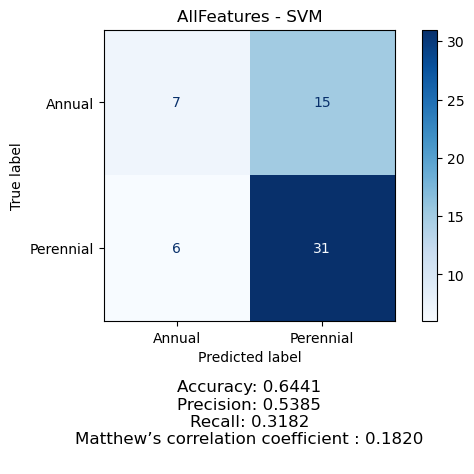

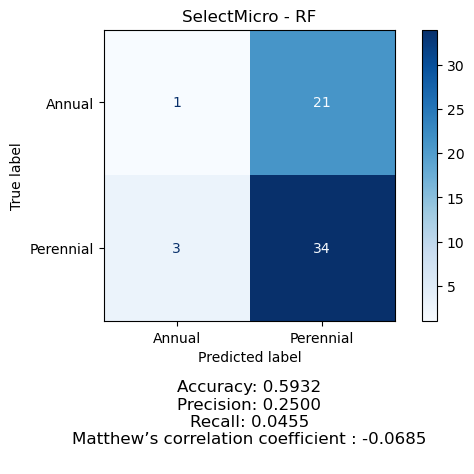

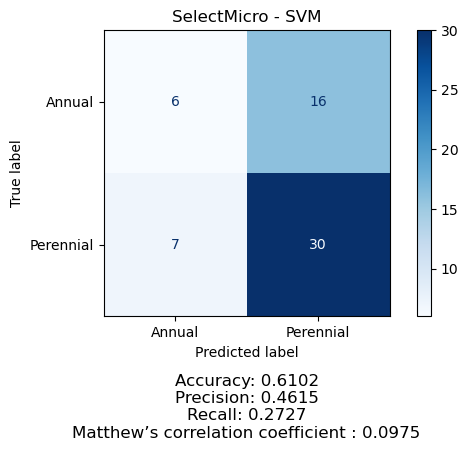

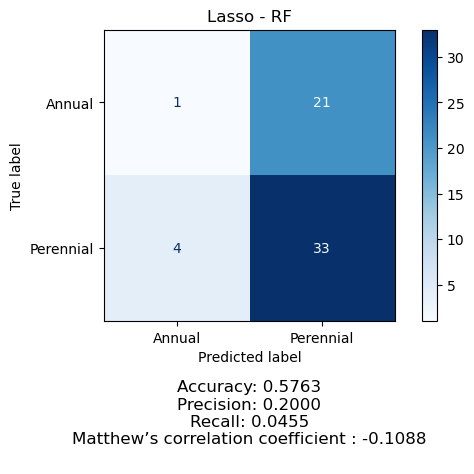

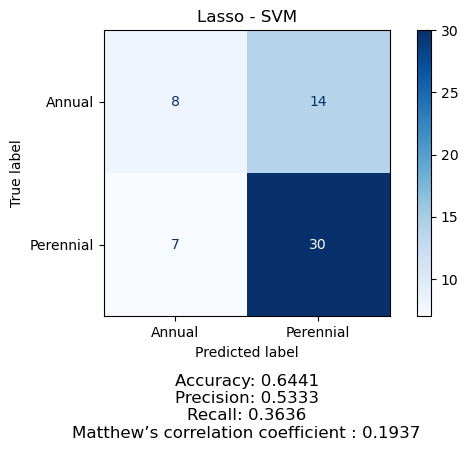

In [33]:
for dataset_name, classifiers in dict_cm_dur.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plot_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}",pos_y='Annual')

## compare the first 15 index

{'Yes', 'No'}
42 17


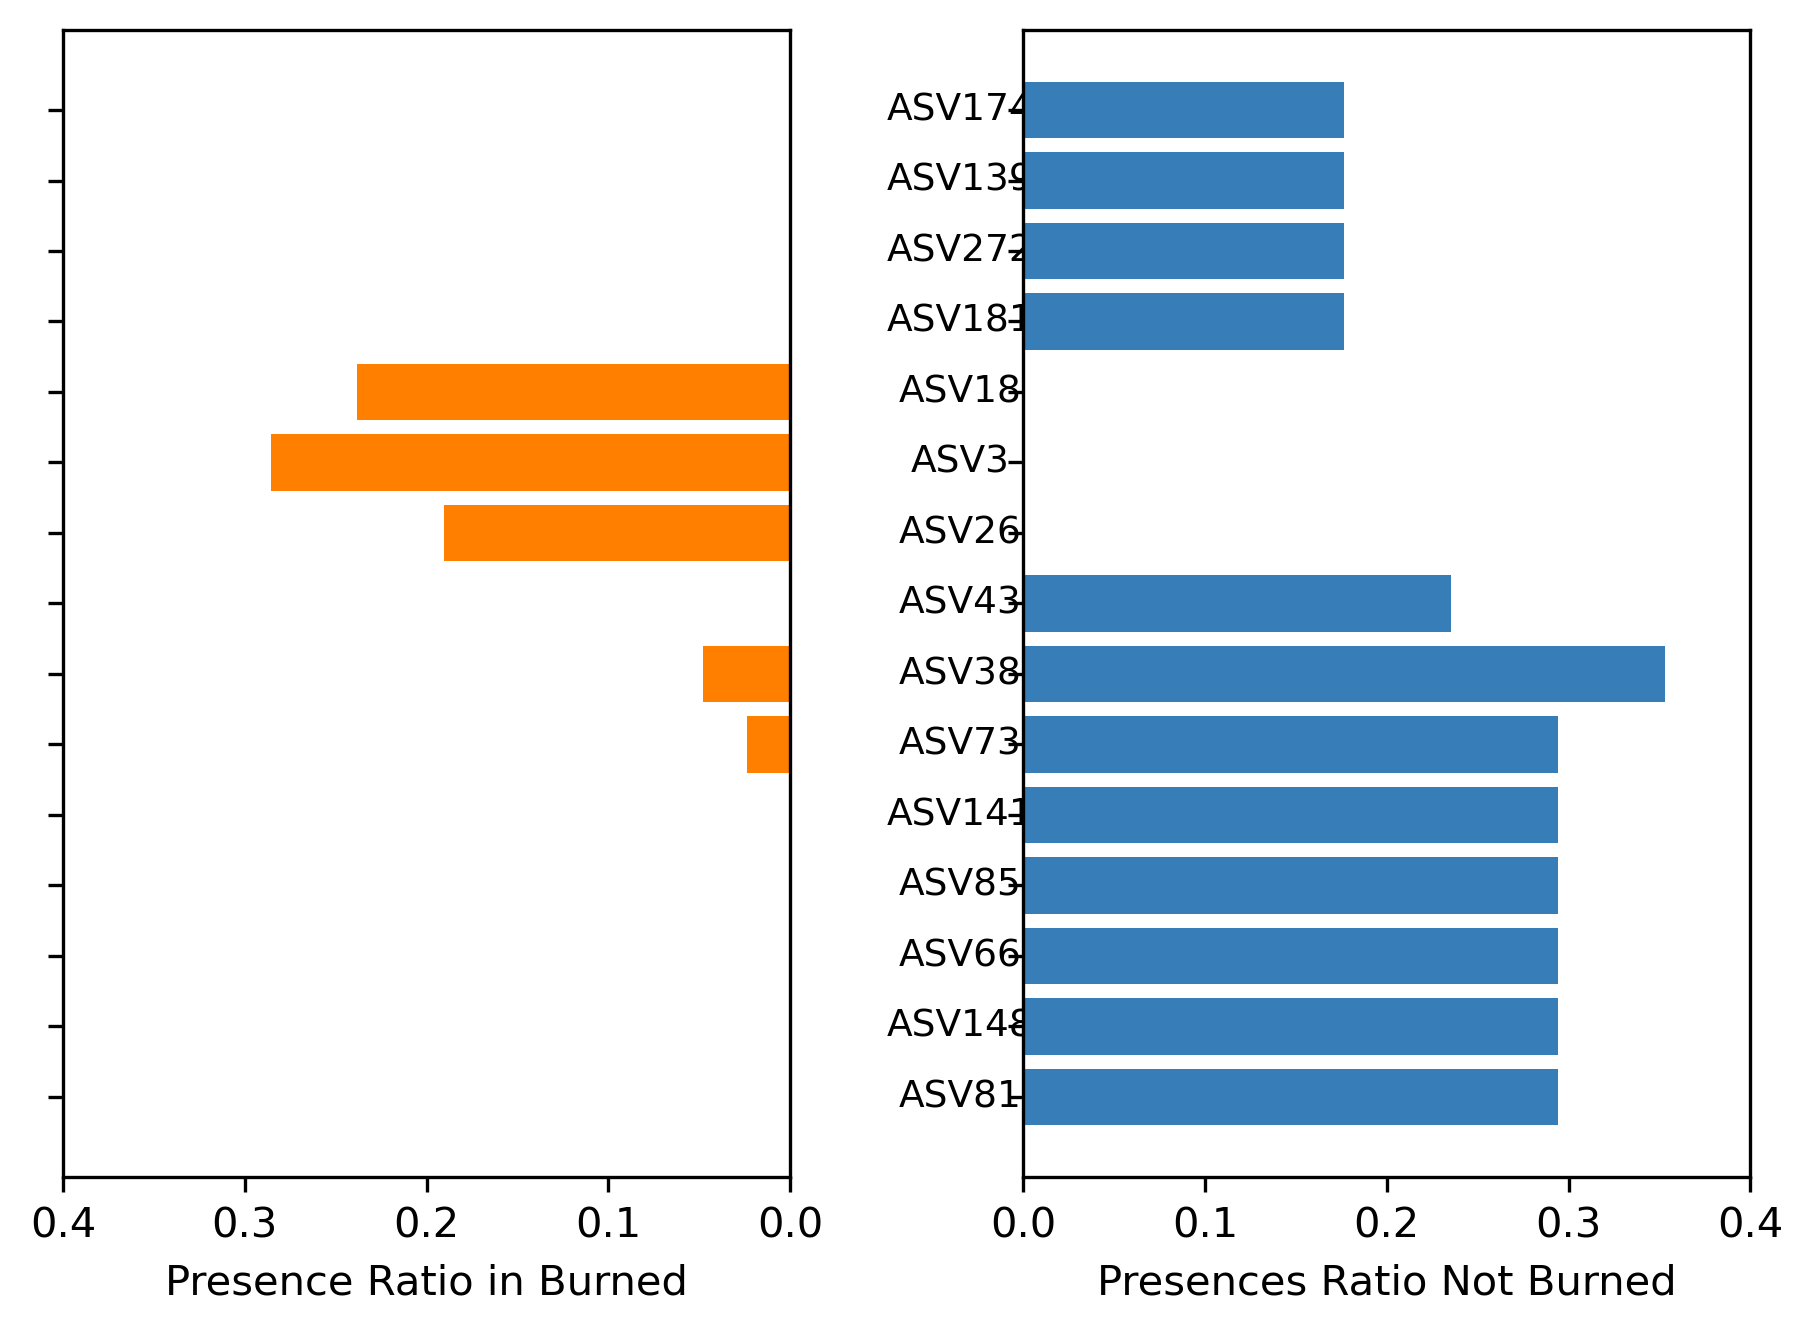

{'Urban', 'Natural'}
26 33


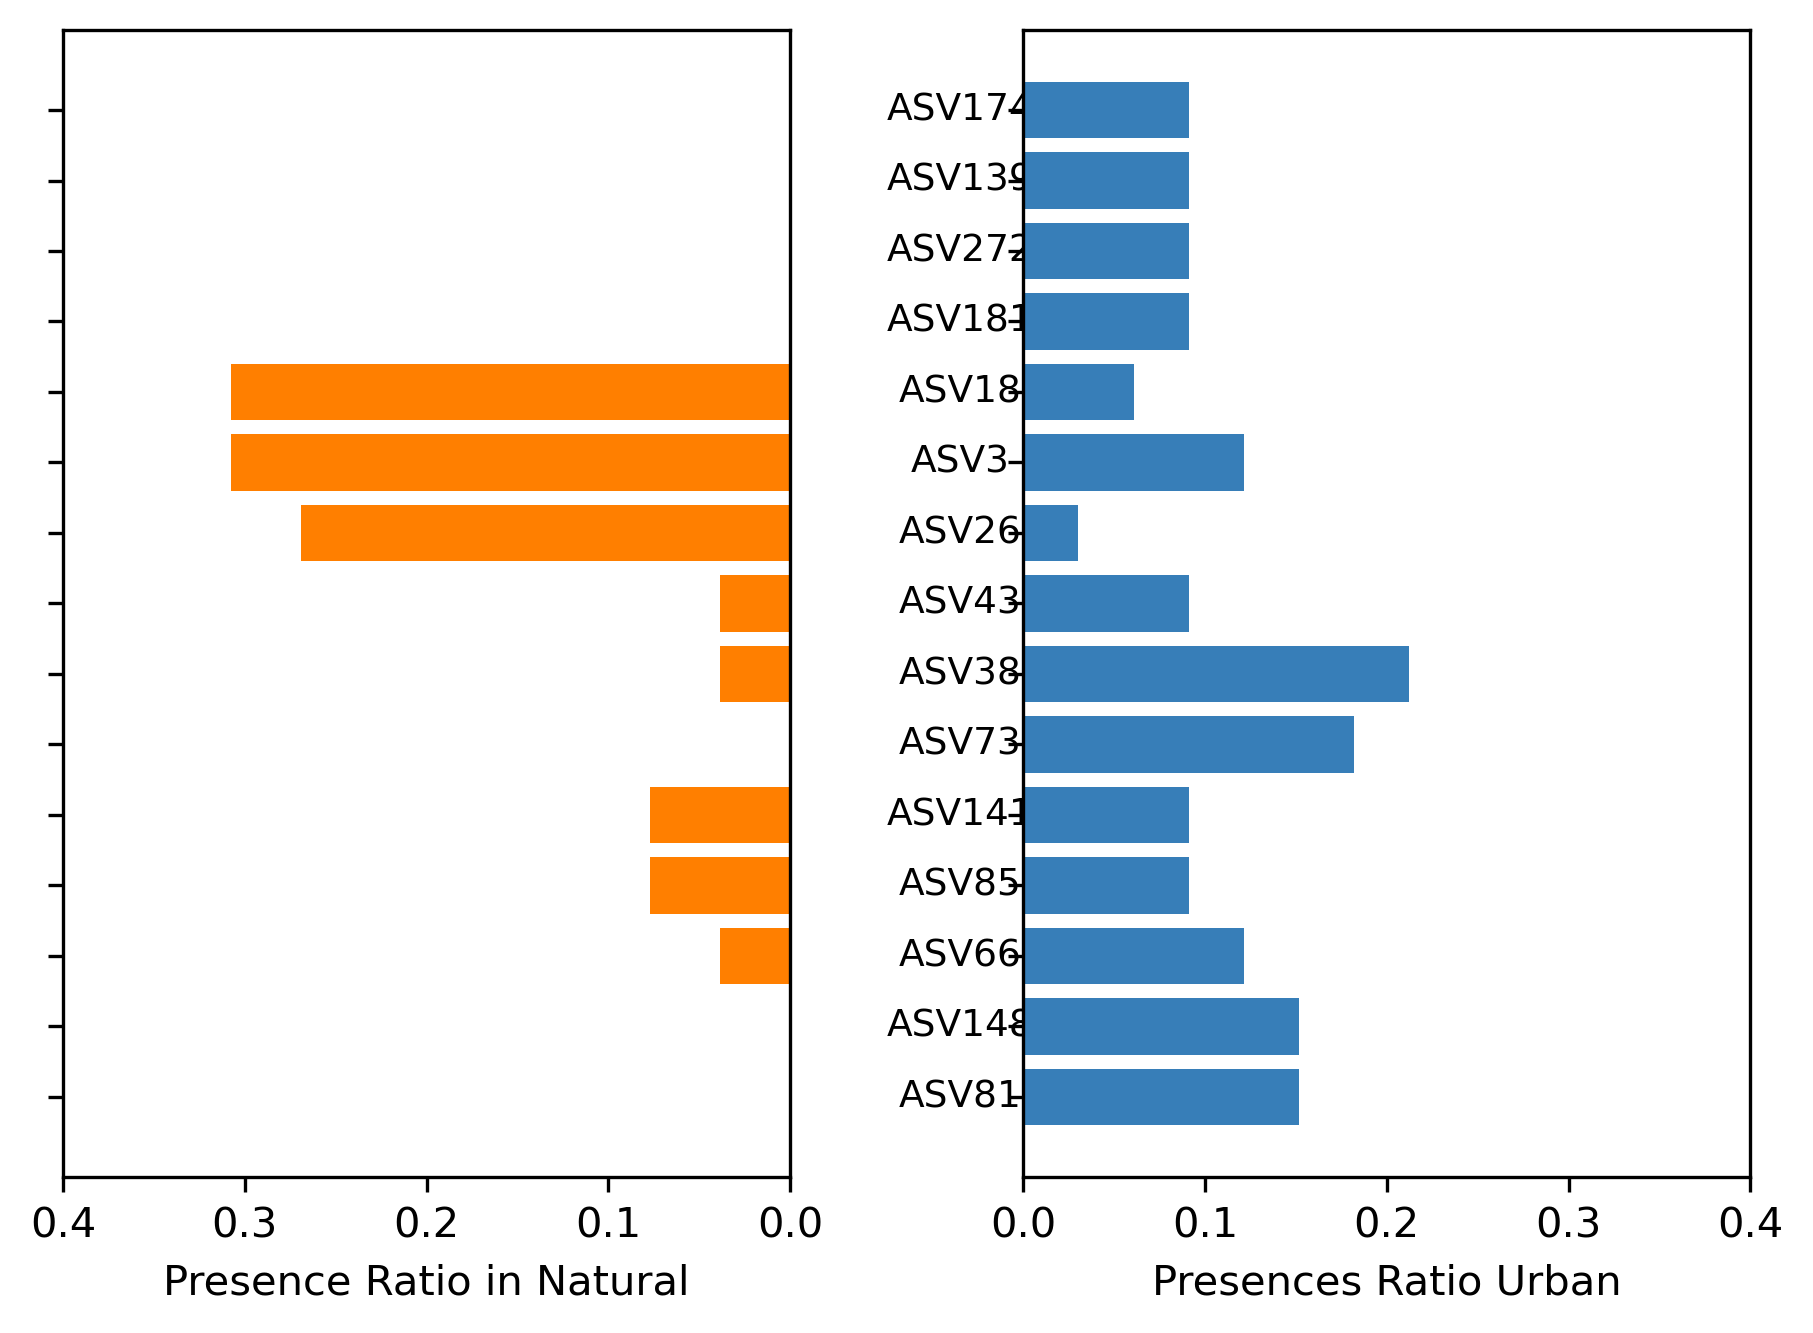

{'Annual', 'Perennial'}
22 37


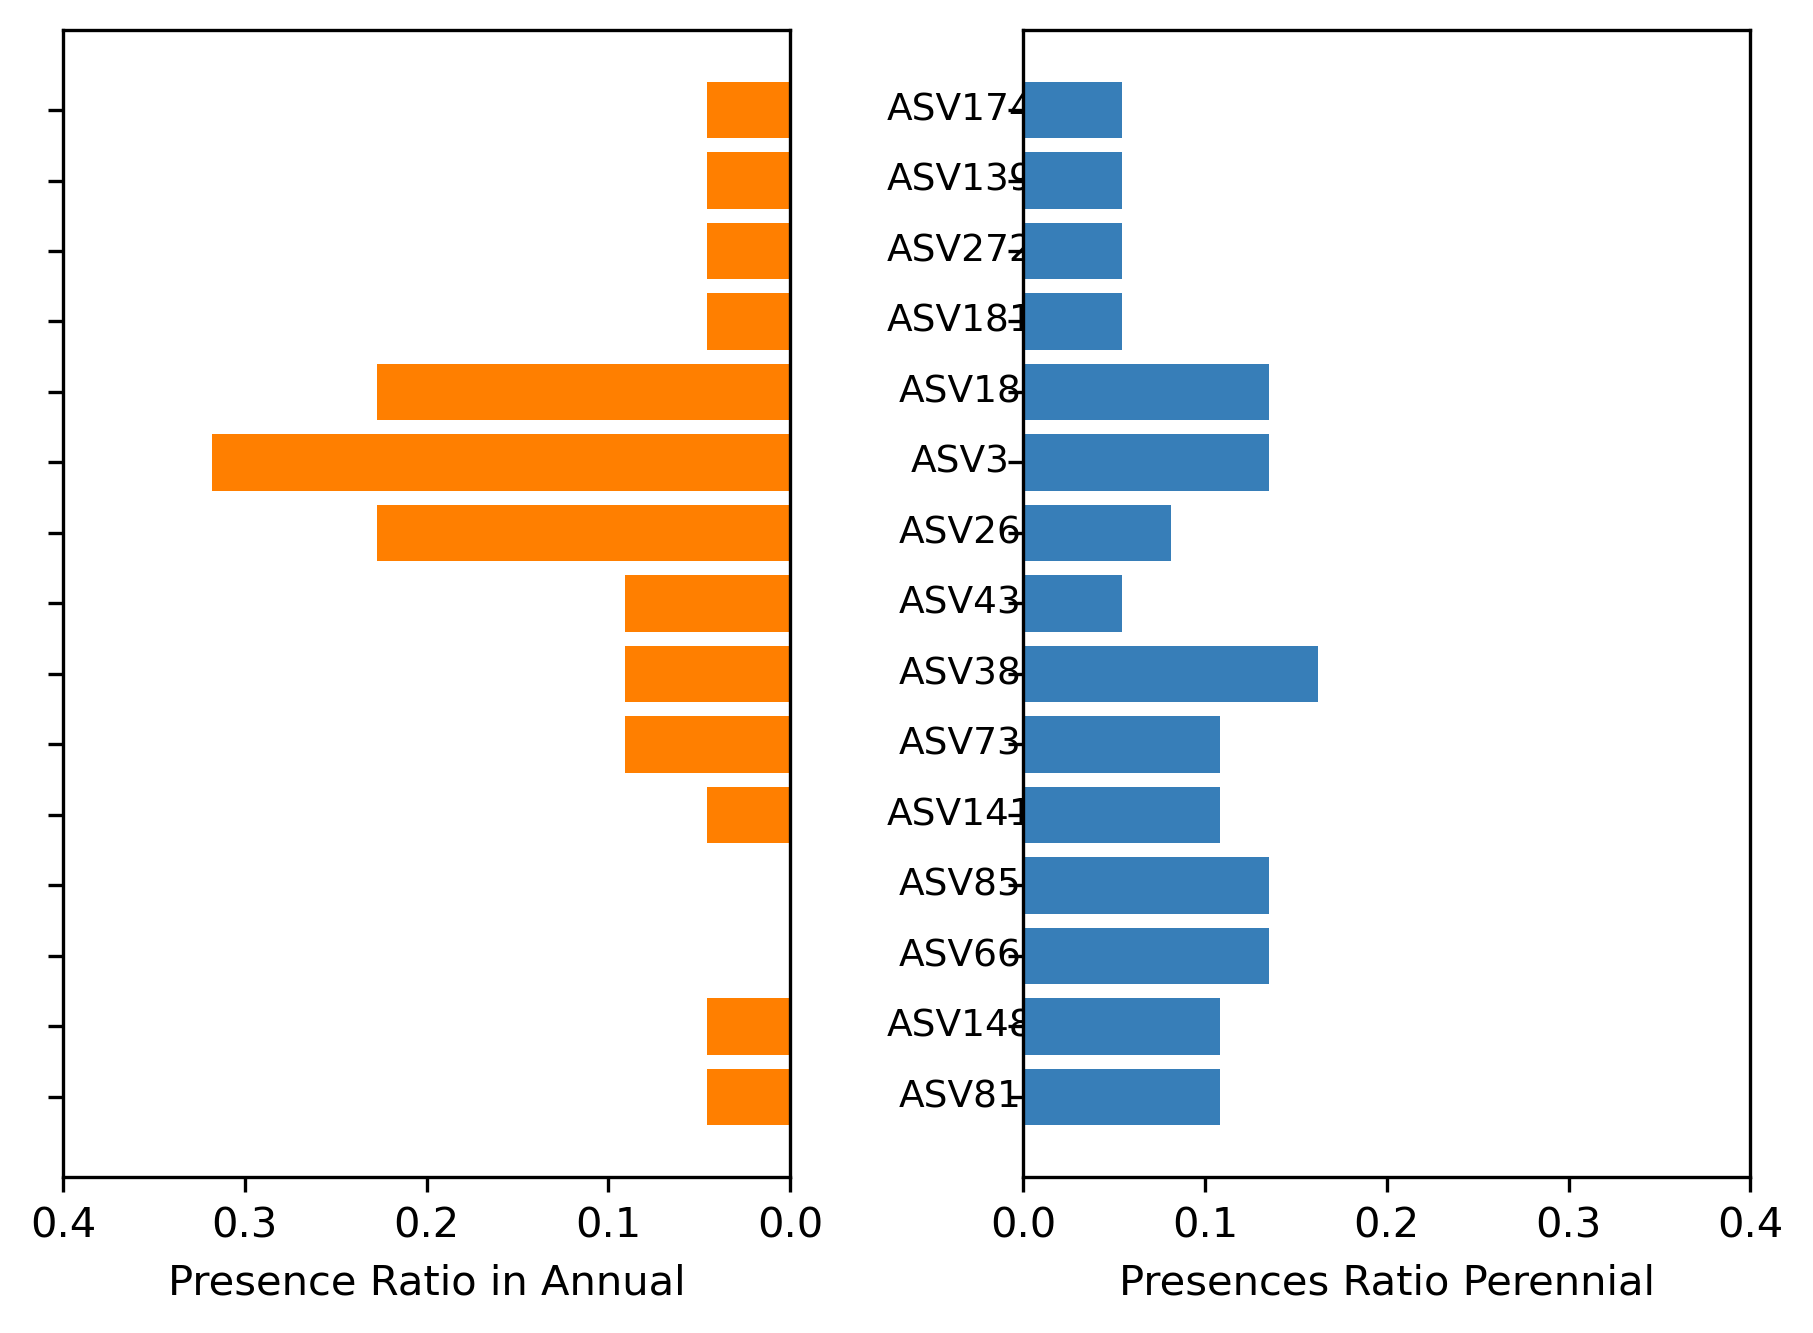

In [34]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]

df=pd.DataFrame(data=X_FS_15)
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

targetLabel=burn_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Yes",posText="Burned",negText="Not Burned",entries=entries)

targetLabel=un_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Natural",posText="Natural",negText="Urban",entries=entries)


targetLabel=duration_label
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="Annual",posText="Annual",negText="Perennial",entries=entries)

In [35]:
X_FS_15

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0., 1763., 1764., 1742.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0., 1763.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [1755., 1757., 1758., 1761.,    0., 1748., 1747.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0., 1753.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [1761., 1752., 1758.,    0.,    0.,    0., 1755.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0., 1745.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,   